In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=2)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR041' 

In [6]:
WuLEVEL = 2
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-4.23731500e-03 -2.21942289e+06]
Y_MAX [4.12299025e-03 2.21981600e+06]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 167500000.0, 0, 0.2]
X_MAX [1, 233750000.0, 7.4, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

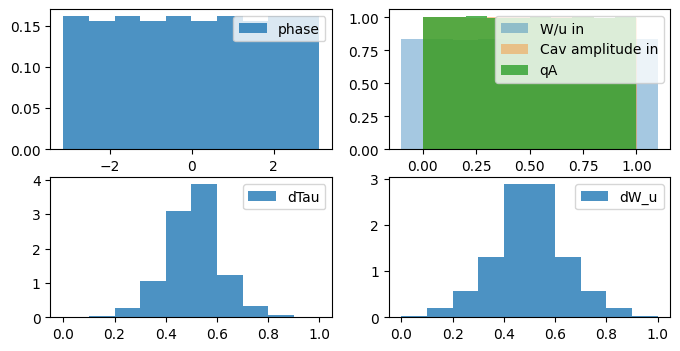

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=2))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 32, 64, 32],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-02-29 18:04
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 5000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL2/model.pt
  - fname_opt: ./WuLEVEL2/optimizer.pt
  - fname_history: ./WuLEVEL2/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:2
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:2
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:2
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:2
 

 Epoch 0067: | Train Loss: 1.25E-07 | Val Loss: 1.09E-07 | lr: 2.50E-05 | 0:29:43.515464
 Epoch 0068: | Train Loss: 1.26E-07 | Val Loss: 1.46E-07 | lr: 2.55E-05 | 0:30:08.829732
 Epoch 0069: | Train Loss: 1.27E-07 | Val Loss: 1.24E-07 | lr: 2.59E-05 | 0:30:34.066594
 Epoch 0070: | Train Loss: 1.28E-07 | Val Loss: 8.50E-08 | lr: 2.63E-05 | 0:30:59.389147
 Epoch 0071: | Train Loss: 1.29E-07 | Val Loss: 9.58E-08 | lr: 2.68E-05 | 0:31:25.691824
 Epoch 0072: | Train Loss: 1.31E-07 | Val Loss: 2.44E-07 | lr: 2.72E-05 | 0:31:51.575008
 Epoch 0073: | Train Loss: 1.32E-07 | Val Loss: 1.04E-07 | lr: 2.76E-05 | 0:32:17.821611
 Epoch 0074: | Train Loss: 1.34E-07 | Val Loss: 1.02E-07 | lr: 2.81E-05 | 0:32:43.474362
 Epoch 0075: | Train Loss: 1.36E-07 | Val Loss: 8.47E-08 | lr: 2.85E-05 | 0:33:09.021613
 Epoch 0076: | Train Loss: 1.36E-07 | Val Loss: 9.98E-07 | lr: 2.90E-05 | 0:33:35.144865
 Epoch 0077: | Train Loss: 1.38E-07 | Val Loss: 2.20E-07 | lr: 2.95E-05 | 0:34:00.867589
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 4.99E-07 | Val Loss: 9.20E-08 | lr: 7.42E-05 | 1:10:16.003232
 Epoch 0161: | Train Loss: 5.01E-07 | Val Loss: 9.20E-08 | lr: 7.47E-05 | 1:10:42.478445
 Epoch 0162: | Train Loss: 5.02E-07 | Val Loss: 1.22E-07 | lr: 7.52E-05 | 1:11:07.875718
 Epoch 0163: | Train Loss: 5.07E-07 | Val Loss: 1.52E-07 | lr: 7.57E-05 | 1:11:32.832509
 Epoch 0164: | Train Loss: 5.07E-07 | Val Loss: 1.03E-07 | lr: 7.62E-05 | 1:11:58.031890
 Epoch 0165: | Train Loss: 5.10E-07 | Val Loss: 3.73E-07 | lr: 7.67E-05 | 1:12:24.176499
 Epoch 0166: | Train Loss: 5.06E-07 | Val Loss: 6.30E-07 | lr: 7.72E-05 | 1:12:49.802993
 Epoch 0167: | Train Loss: 5.16E-07 | Val Loss: 5.29E-07 | lr: 7.77E-05 | 1:13:15.231429
 Epoch 0168: | Train Loss: 5.14E-07 | Val Loss: 1.25E-07 | lr: 7.81E-05 | 1:13:41.286339
 Epoch 0169: | Train Loss: 5.12E-07 | Val Loss: 1.20E-07 | lr: 7.86E-05 | 1:14:06.096913
 Epoch 0170: | Train Loss: 5.16E-07 | Val Loss: 9.98E-08 | lr: 7.91E-05 | 1:14:31.440241
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 3.48E-07 | Val Loss: 1.07E-06 | lr: 1.00E-04 | 1:50:31.077852
 Epoch 0254: | Train Loss: 3.44E-07 | Val Loss: 1.01E-07 | lr: 1.00E-04 | 1:50:57.884648
 Epoch 0255: | Train Loss: 3.41E-07 | Val Loss: 9.35E-08 | lr: 1.00E-04 | 1:51:24.767494
 Epoch 0256: | Train Loss: 3.37E-07 | Val Loss: 4.89E-08 | lr: 1.00E-04 | 1:51:50.673765
 Epoch 0257: | Train Loss: 3.34E-07 | Val Loss: 2.74E-07 | lr: 1.00E-04 | 1:52:16.600119
 Epoch 0258: | Train Loss: 3.31E-07 | Val Loss: 7.30E-08 | lr: 1.00E-04 | 1:52:42.526370
 Epoch 0259: | Train Loss: 3.27E-07 | Val Loss: 6.82E-08 | lr: 1.00E-04 | 1:53:08.885276
 Epoch 0260: | Train Loss: 3.26E-07 | Val Loss: 3.31E-07 | lr: 1.00E-04 | 1:53:35.338803
 Epoch 0261: | Train Loss: 3.21E-07 | Val Loss: 1.33E-07 | lr: 1.00E-04 | 1:54:01.007320
 Epoch 0262: | Train Loss: 3.18E-07 | Val Loss: 7.68E-08 | lr: 1.00E-04 | 1:54:27.205997
 Epoch 0263: | Train Loss: 3.16E-07 | Val Loss: 1.28E-06 | lr: 1.00E-04 | 1:54:54.434507
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.75E-07 | Val Loss: 1.44E-07 | lr: 9.99E-05 | 2:32:47.048801
 Epoch 0347: | Train Loss: 1.74E-07 | Val Loss: 1.10E-07 | lr: 9.99E-05 | 2:33:12.738993
 Epoch 0348: | Train Loss: 1.73E-07 | Val Loss: 2.52E-07 | lr: 9.99E-05 | 2:33:38.541279
 Epoch 0349: | Train Loss: 1.73E-07 | Val Loss: 2.01E-07 | lr: 9.99E-05 | 2:34:04.205971
 Epoch 0350: | Train Loss: 1.71E-07 | Val Loss: 3.11E-08 | lr: 9.99E-05 | 2:34:33.835770
 Epoch 0351: | Train Loss: 1.70E-07 | Val Loss: 5.68E-07 | lr: 9.99E-05 | 2:35:04.376326
 Epoch 0352: | Train Loss: 1.70E-07 | Val Loss: 3.27E-07 | lr: 9.99E-05 | 2:35:32.017732
 Epoch 0353: | Train Loss: 1.68E-07 | Val Loss: 3.59E-08 | lr: 9.99E-05 | 2:35:58.583249
 Epoch 0354: | Train Loss: 1.68E-07 | Val Loss: 4.93E-08 | lr: 9.99E-05 | 2:36:26.198372
 Epoch 0355: | Train Loss: 1.67E-07 | Val Loss: 2.82E-07 | lr: 9.99E-05 | 2:36:51.750535
 Epoch 0356: | Train Loss: 1.65E-07 | Val Loss: 4.09E-08 | lr: 9.99E-05 | 2:37:17.129926
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.13E-07 | Val Loss: 1.02E-07 | lr: 9.96E-05 | 3:14:43.884634
 Epoch 0440: | Train Loss: 1.11E-07 | Val Loss: 1.68E-08 | lr: 9.96E-05 | 3:15:10.147393
 Epoch 0441: | Train Loss: 1.11E-07 | Val Loss: 1.81E-07 | lr: 9.96E-05 | 3:15:36.892325
 Epoch 0442: | Train Loss: 1.11E-07 | Val Loss: 2.22E-08 | lr: 9.96E-05 | 3:16:02.167760
 Epoch 0443: | Train Loss: 1.10E-07 | Val Loss: 1.66E-08 | lr: 9.96E-05 | 3:16:27.329497
 Epoch 0444: | Train Loss: 1.10E-07 | Val Loss: 8.05E-07 | lr: 9.96E-05 | 3:16:53.349535
 Epoch 0445: | Train Loss: 1.09E-07 | Val Loss: 2.03E-07 | lr: 9.96E-05 | 3:17:19.498928
 Epoch 0446: | Train Loss: 1.09E-07 | Val Loss: 2.06E-08 | lr: 9.96E-05 | 3:17:47.223910
 Epoch 0447: | Train Loss: 1.08E-07 | Val Loss: 1.56E-08 | lr: 9.96E-05 | 3:18:15.115889
 Epoch 0448: | Train Loss: 1.08E-07 | Val Loss: 3.89E-07 | lr: 9.96E-05 | 3:18:41.231081
 Epoch 0449: | Train Loss: 1.07E-07 | Val Loss: 1.68E-08 | lr: 9.96E-05 | 3:19:06.995433
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 7.68E-08 | Val Loss: 2.47E-08 | lr: 9.91E-05 | 3:55:49.618526
 Epoch 0533: | Train Loss: 7.66E-08 | Val Loss: 1.76E-07 | lr: 9.91E-05 | 3:56:15.210202
 Epoch 0534: | Train Loss: 7.65E-08 | Val Loss: 2.53E-08 | lr: 9.91E-05 | 3:56:39.952777
 Epoch 0535: | Train Loss: 7.57E-08 | Val Loss: 1.38E-07 | lr: 9.91E-05 | 3:57:05.143494
 Epoch 0536: | Train Loss: 7.57E-08 | Val Loss: 5.11E-08 | lr: 9.91E-05 | 3:57:31.088906
 Epoch 0537: | Train Loss: 7.54E-08 | Val Loss: 1.46E-08 | lr: 9.91E-05 | 3:57:57.722429
 Epoch 0538: | Train Loss: 7.49E-08 | Val Loss: 1.92E-08 | lr: 9.91E-05 | 3:58:23.588483
 Epoch 0539: | Train Loss: 7.49E-08 | Val Loss: 4.53E-08 | lr: 9.91E-05 | 3:58:50.941621
 Epoch 0540: | Train Loss: 7.43E-08 | Val Loss: 3.29E-08 | lr: 9.91E-05 | 3:59:16.868125
 Epoch 0541: | Train Loss: 7.43E-08 | Val Loss: 4.27E-08 | lr: 9.91E-05 | 3:59:42.434263
 Epoch 0542: | Train Loss: 7.37E-08 | Val Loss: 8.71E-08 | lr: 9.91E-05 | 4:00:07.828007
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.39E-08 | Val Loss: 8.80E-09 | lr: 9.85E-05 | 4:36:52.080751
 Epoch 0626: | Train Loss: 5.37E-08 | Val Loss: 3.91E-08 | lr: 9.85E-05 | 4:37:18.889456
 Epoch 0627: | Train Loss: 5.39E-08 | Val Loss: 1.03E-08 | lr: 9.85E-05 | 4:37:49.448963
 Epoch 0628: | Train Loss: 5.32E-08 | Val Loss: 2.73E-08 | lr: 9.84E-05 | 4:38:15.416402
 Epoch 0629: | Train Loss: 5.31E-08 | Val Loss: 2.19E-08 | lr: 9.84E-05 | 4:38:41.244400
 Epoch 0630: | Train Loss: 5.30E-08 | Val Loss: 2.41E-08 | lr: 9.84E-05 | 4:39:08.042191
 Epoch 0631: | Train Loss: 5.28E-08 | Val Loss: 1.38E-08 | lr: 9.84E-05 | 4:39:38.671060
 Epoch 0632: | Train Loss: 5.26E-08 | Val Loss: 6.40E-08 | lr: 9.84E-05 | 4:40:05.367339
 Epoch 0633: | Train Loss: 5.23E-08 | Val Loss: 1.08E-08 | lr: 9.84E-05 | 4:40:31.855382
 Epoch 0634: | Train Loss: 5.21E-08 | Val Loss: 4.45E-08 | lr: 9.84E-05 | 4:40:57.349857
 Epoch 0635: | Train Loss: 5.21E-08 | Val Loss: 1.59E-08 | lr: 9.84E-05 | 4:41:23.456386
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 3.93E-08 | Val Loss: 1.34E-08 | lr: 9.76E-05 | 5:18:55.755426
 Epoch 0719: | Train Loss: 3.92E-08 | Val Loss: 1.26E-08 | lr: 9.76E-05 | 5:19:21.781992
 Epoch 0720: | Train Loss: 3.91E-08 | Val Loss: 1.01E-08 | lr: 9.76E-05 | 5:19:48.012030
 Epoch 0721: | Train Loss: 3.89E-08 | Val Loss: 1.30E-08 | lr: 9.76E-05 | 5:20:13.845344
 Epoch 0722: | Train Loss: 3.88E-08 | Val Loss: 1.64E-07 | lr: 9.76E-05 | 5:20:39.096913
 Epoch 0723: | Train Loss: 3.86E-08 | Val Loss: 6.63E-09 | lr: 9.76E-05 | 5:21:05.038585
 Epoch 0724: | Train Loss: 3.86E-08 | Val Loss: 1.29E-08 | lr: 9.76E-05 | 5:21:30.660782
 Epoch 0725: | Train Loss: 3.84E-08 | Val Loss: 1.31E-07 | lr: 9.76E-05 | 5:22:01.999294
 Epoch 0726: | Train Loss: 3.84E-08 | Val Loss: 7.11E-08 | lr: 9.75E-05 | 5:22:29.683716
 Epoch 0727: | Train Loss: 3.83E-08 | Val Loss: 8.04E-09 | lr: 9.75E-05 | 5:22:55.971101
 Epoch 0728: | Train Loss: 3.81E-08 | Val Loss: 7.35E-09 | lr: 9.75E-05 | 5:23:22.618804
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 3.04E-08 | Val Loss: 7.12E-09 | lr: 9.66E-05 | 5:59:58.618044
 Epoch 0812: | Train Loss: 3.04E-08 | Val Loss: 3.21E-08 | lr: 9.66E-05 | 6:00:23.658927
 Epoch 0813: | Train Loss: 3.04E-08 | Val Loss: 1.20E-08 | lr: 9.66E-05 | 6:00:48.387444
 Epoch 0814: | Train Loss: 3.01E-08 | Val Loss: 8.05E-09 | lr: 9.66E-05 | 6:01:13.066561
 Epoch 0815: | Train Loss: 3.02E-08 | Val Loss: 5.21E-08 | lr: 9.65E-05 | 6:01:38.558589
 Epoch 0816: | Train Loss: 3.01E-08 | Val Loss: 9.36E-09 | lr: 9.65E-05 | 6:02:04.290490
 Epoch 0817: | Train Loss: 2.99E-08 | Val Loss: 9.02E-09 | lr: 9.65E-05 | 6:02:30.259473
 Epoch 0818: | Train Loss: 2.99E-08 | Val Loss: 8.39E-08 | lr: 9.65E-05 | 6:02:56.126097
 Epoch 0819: | Train Loss: 2.99E-08 | Val Loss: 7.31E-08 | lr: 9.65E-05 | 6:03:22.327050
 Epoch 0820: | Train Loss: 2.99E-08 | Val Loss: 6.75E-09 | lr: 9.65E-05 | 6:03:48.735892
 Epoch 0821: | Train Loss: 2.96E-08 | Val Loss: 2.48E-08 | lr: 9.65E-05 | 6:04:14.990775
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.52E-08 | Val Loss: 5.65E-09 | lr: 9.54E-05 | 6:40:45.213718
 Epoch 0905: | Train Loss: 2.50E-08 | Val Loss: 1.17E-08 | lr: 9.54E-05 | 6:41:11.068467
 Epoch 0906: | Train Loss: 2.49E-08 | Val Loss: 2.44E-08 | lr: 9.54E-05 | 6:41:36.580461
 Epoch 0907: | Train Loss: 2.50E-08 | Val Loss: 1.46E-08 | lr: 9.54E-05 | 6:42:01.869708
 Epoch 0908: | Train Loss: 2.48E-08 | Val Loss: 1.15E-08 | lr: 9.53E-05 | 6:42:28.443704
 Epoch 0909: | Train Loss: 2.49E-08 | Val Loss: 6.60E-09 | lr: 9.53E-05 | 6:42:55.785070
 Epoch 0910: | Train Loss: 2.48E-08 | Val Loss: 7.31E-08 | lr: 9.53E-05 | 6:43:21.991406
 Epoch 0911: | Train Loss: 2.48E-08 | Val Loss: 2.22E-08 | lr: 9.53E-05 | 6:43:48.095792
 Epoch 0912: | Train Loss: 2.47E-08 | Val Loss: 7.37E-09 | lr: 9.53E-05 | 6:44:21.384472
 Epoch 0913: | Train Loss: 2.46E-08 | Val Loss: 5.26E-09 | lr: 9.53E-05 | 6:44:48.152305
 Epoch 0914: | Train Loss: 2.47E-08 | Val Loss: 9.41E-09 | lr: 9.53E-05 | 6:45:16.319942
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 2.12E-08 | Val Loss: 3.19E-08 | lr: 9.40E-05 | 7:22:39.065512
 Epoch 0998: | Train Loss: 2.12E-08 | Val Loss: 6.01E-09 | lr: 9.40E-05 | 7:23:10.786151
 Epoch 0999: | Train Loss: 2.12E-08 | Val Loss: 8.38E-09 | lr: 9.40E-05 | 7:23:39.901647
 Epoch 1000: | Train Loss: 2.11E-08 | Val Loss: 6.78E-08 | lr: 9.40E-05 | 7:24:05.648575
 Epoch 1001: | Train Loss: 2.11E-08 | Val Loss: 1.35E-08 | lr: 9.40E-05 | 7:24:31.462311
 Epoch 1002: | Train Loss: 2.09E-08 | Val Loss: 8.45E-08 | lr: 9.39E-05 | 7:24:58.044353
 Epoch 1003: | Train Loss: 2.10E-08 | Val Loss: 3.35E-08 | lr: 9.39E-05 | 7:25:25.102783
 Epoch 1004: | Train Loss: 2.10E-08 | Val Loss: 1.85E-08 | lr: 9.39E-05 | 7:25:51.707138
 Epoch 1005: | Train Loss: 2.09E-08 | Val Loss: 6.25E-08 | lr: 9.39E-05 | 7:26:18.246429
 Epoch 1006: | Train Loss: 2.10E-08 | Val Loss: 5.60E-09 | lr: 9.39E-05 | 7:26:44.028080
 Epoch 1007: | Train Loss: 2.08E-08 | Val Loss: 6.74E-08 | lr: 9.39E-05 | 7:27:09.597889
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.83E-08 | Val Loss: 9.57E-09 | lr: 9.25E-05 | 8:04:40.190989
 Epoch 1091: | Train Loss: 1.84E-08 | Val Loss: 1.59E-08 | lr: 9.25E-05 | 8:05:06.128703
 Epoch 1092: | Train Loss: 1.83E-08 | Val Loss: 8.00E-09 | lr: 9.24E-05 | 8:05:31.903198
 Epoch 1093: | Train Loss: 1.84E-08 | Val Loss: 4.98E-09 | lr: 9.24E-05 | 8:05:57.920090
 Epoch 1094: | Train Loss: 1.83E-08 | Val Loss: 2.46E-08 | lr: 9.24E-05 | 8:06:23.736413
 Epoch 1095: | Train Loss: 1.83E-08 | Val Loss: 1.88E-08 | lr: 9.24E-05 | 8:06:49.607034
 Epoch 1096: | Train Loss: 1.82E-08 | Val Loss: 4.52E-09 | lr: 9.24E-05 | 8:07:17.502456
 Epoch 1097: | Train Loss: 1.83E-08 | Val Loss: 3.92E-09 | lr: 9.24E-05 | 8:07:43.388688
 Epoch 1098: | Train Loss: 1.81E-08 | Val Loss: 2.57E-08 | lr: 9.23E-05 | 8:08:09.664979
 Epoch 1099: | Train Loss: 1.82E-08 | Val Loss: 1.82E-08 | lr: 9.23E-05 | 8:08:36.232951
 Epoch 1100: | Train Loss: 1.81E-08 | Val Loss: 9.32E-09 | lr: 9.23E-05 | 8:09:02.432421
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.61E-08 | Val Loss: 6.70E-09 | lr: 9.08E-05 | 8:45:39.809553
 Epoch 1184: | Train Loss: 1.60E-08 | Val Loss: 5.73E-09 | lr: 9.08E-05 | 8:46:10.015407
 Epoch 1185: | Train Loss: 1.61E-08 | Val Loss: 4.06E-09 | lr: 9.07E-05 | 8:46:37.843298
 Epoch 1186: | Train Loss: 1.60E-08 | Val Loss: 2.07E-08 | lr: 9.07E-05 | 8:47:08.091069
 Epoch 1187: | Train Loss: 1.61E-08 | Val Loss: 6.21E-09 | lr: 9.07E-05 | 8:47:34.462842
 Epoch 1188: | Train Loss: 1.60E-08 | Val Loss: 6.11E-09 | lr: 9.07E-05 | 8:48:01.971018
 Epoch 1189: | Train Loss: 1.60E-08 | Val Loss: 6.94E-09 | lr: 9.07E-05 | 8:48:28.282654
 Epoch 1190: | Train Loss: 1.59E-08 | Val Loss: 2.24E-08 | lr: 9.06E-05 | 8:48:54.206902
 Epoch 1191: | Train Loss: 1.60E-08 | Val Loss: 4.69E-09 | lr: 9.06E-05 | 8:49:20.223983
 Epoch 1192: | Train Loss: 1.59E-08 | Val Loss: 1.28E-08 | lr: 9.06E-05 | 8:49:46.979223
 Epoch 1193: | Train Loss: 1.59E-08 | Val Loss: 4.29E-09 | lr: 9.06E-05 | 8:50:13.318409
 Epoch 1194: | Train 

 Epoch 1276: | Train Loss: 1.43E-08 | Val Loss: 3.31E-09 | lr: 8.89E-05 | 9:27:43.683610
 Epoch 1277: | Train Loss: 1.42E-08 | Val Loss: 2.39E-08 | lr: 8.89E-05 | 9:28:09.929275
 Epoch 1278: | Train Loss: 1.42E-08 | Val Loss: 1.69E-08 | lr: 8.89E-05 | 9:28:37.486975
 Epoch 1279: | Train Loss: 1.42E-08 | Val Loss: 5.25E-09 | lr: 8.89E-05 | 9:29:05.009129
 Epoch 1280: | Train Loss: 1.42E-08 | Val Loss: 3.60E-09 | lr: 8.88E-05 | 9:29:31.589258
 Epoch 1281: | Train Loss: 1.41E-08 | Val Loss: 8.55E-09 | lr: 8.88E-05 | 9:29:58.024298
 Epoch 1282: | Train Loss: 1.41E-08 | Val Loss: 1.69E-08 | lr: 8.88E-05 | 9:30:26.298648
 Epoch 1283: | Train Loss: 1.41E-08 | Val Loss: 1.46E-08 | lr: 8.88E-05 | 9:30:53.786465
 Epoch 1284: | Train Loss: 1.40E-08 | Val Loss: 2.61E-08 | lr: 8.88E-05 | 9:31:18.910910
 Epoch 1285: | Train Loss: 1.41E-08 | Val Loss: 1.07E-08 | lr: 8.87E-05 | 9:31:44.763155
 Epoch 1286: | Train Loss: 1.40E-08 | Val Loss: 4.99E-08 | lr: 8.87E-05 | 9:32:10.761732
 Epoch 1287: | Train 

 Epoch 1368: | Train Loss: 1.25E-08 | Val Loss: 3.90E-09 | lr: 8.69E-05 | 10:08:24.354652
 Epoch 1369: | Train Loss: 1.26E-08 | Val Loss: 5.29E-08 | lr: 8.69E-05 | 10:08:51.622334
 Epoch 1370: | Train Loss: 1.26E-08 | Val Loss: 6.86E-09 | lr: 8.69E-05 | 10:09:25.312211
 Epoch 1371: | Train Loss: 1.26E-08 | Val Loss: 3.67E-09 | lr: 8.69E-05 | 10:09:51.982767
 Epoch 1372: | Train Loss: 1.25E-08 | Val Loss: 3.65E-08 | lr: 8.69E-05 | 10:10:17.461518
 Epoch 1373: | Train Loss: 1.25E-08 | Val Loss: 3.85E-09 | lr: 8.68E-05 | 10:10:43.123599
 Epoch 1374: | Train Loss: 1.25E-08 | Val Loss: 3.27E-09 | lr: 8.68E-05 | 10:11:09.359147
 Epoch 1375: | Train Loss: 1.25E-08 | Val Loss: 9.44E-09 | lr: 8.68E-05 | 10:11:34.981273
 Epoch 1376: | Train Loss: 1.25E-08 | Val Loss: 3.31E-09 | lr: 8.68E-05 | 10:12:01.754104
 Epoch 1377: | Train Loss: 1.24E-08 | Val Loss: 2.44E-08 | lr: 8.67E-05 | 10:12:29.051880
 Epoch 1378: | Train Loss: 1.24E-08 | Val Loss: 5.74E-09 | lr: 8.67E-05 | 10:12:57.263153
 Epoch 137

 Epoch 1460: | Train Loss: 1.12E-08 | Val Loss: 3.20E-09 | lr: 8.48E-05 | 10:49:23.883231
 Epoch 1461: | Train Loss: 1.12E-08 | Val Loss: 2.65E-09 | lr: 8.48E-05 | 10:49:50.555624
 Epoch 1462: | Train Loss: 1.12E-08 | Val Loss: 4.00E-09 | lr: 8.48E-05 | 10:50:16.445051
 Epoch 1463: | Train Loss: 1.11E-08 | Val Loss: 6.28E-09 | lr: 8.48E-05 | 10:50:42.467869
 Epoch 1464: | Train Loss: 1.12E-08 | Val Loss: 2.90E-09 | lr: 8.47E-05 | 10:51:08.861979
 Epoch 1465: | Train Loss: 1.11E-08 | Val Loss: 4.03E-08 | lr: 8.47E-05 | 10:51:35.504968
 Epoch 1466: | Train Loss: 1.11E-08 | Val Loss: 6.32E-09 | lr: 8.47E-05 | 10:52:00.715321
 Epoch 1467: | Train Loss: 1.11E-08 | Val Loss: 5.10E-09 | lr: 8.47E-05 | 10:52:26.977256
 Epoch 1468: | Train Loss: 1.10E-08 | Val Loss: 4.74E-09 | lr: 8.46E-05 | 10:52:53.703617
 Epoch 1469: | Train Loss: 1.11E-08 | Val Loss: 3.67E-09 | lr: 8.46E-05 | 10:53:27.780592
 Epoch 1470: | Train Loss: 1.10E-08 | Val Loss: 4.15E-09 | lr: 8.46E-05 | 10:53:56.867733
 Epoch 147

 Epoch 1552: | Train Loss: 9.97E-09 | Val Loss: 5.71E-09 | lr: 8.26E-05 | 11:30:18.576973
 Epoch 1553: | Train Loss: 9.94E-09 | Val Loss: 3.70E-09 | lr: 8.26E-05 | 11:30:45.389237
 Epoch 1554: | Train Loss: 9.92E-09 | Val Loss: 4.52E-09 | lr: 8.25E-05 | 11:31:13.991567
 Epoch 1555: | Train Loss: 9.92E-09 | Val Loss: 5.80E-09 | lr: 8.25E-05 | 11:31:44.362921
 Epoch 1556: | Train Loss: 9.93E-09 | Val Loss: 2.84E-09 | lr: 8.25E-05 | 11:32:12.702873
 Epoch 1557: | Train Loss: 9.89E-09 | Val Loss: 3.26E-08 | lr: 8.25E-05 | 11:32:42.676265
 Epoch 1558: | Train Loss: 9.86E-09 | Val Loss: 3.57E-09 | lr: 8.24E-05 | 11:33:12.238727
 Epoch 1559: | Train Loss: 9.87E-09 | Val Loss: 3.30E-08 | lr: 8.24E-05 | 11:33:41.366960
 Epoch 1560: | Train Loss: 9.85E-09 | Val Loss: 3.12E-09 | lr: 8.24E-05 | 11:34:08.219376
 Epoch 1561: | Train Loss: 9.84E-09 | Val Loss: 1.48E-08 | lr: 8.24E-05 | 11:34:35.454173
 Epoch 1562: | Train Loss: 9.88E-09 | Val Loss: 3.38E-09 | lr: 8.23E-05 | 11:35:04.329515
 Epoch 156

 Epoch 1644: | Train Loss: 8.87E-09 | Val Loss: 9.46E-09 | lr: 8.02E-05 | 12:12:26.619513
 Epoch 1645: | Train Loss: 8.87E-09 | Val Loss: 2.51E-09 | lr: 8.02E-05 | 12:12:51.950773
 Epoch 1646: | Train Loss: 8.82E-09 | Val Loss: 8.21E-09 | lr: 8.02E-05 | 12:13:17.299000
 Epoch 1647: | Train Loss: 8.82E-09 | Val Loss: 2.97E-09 | lr: 8.01E-05 | 12:13:43.615348
 Epoch 1648: | Train Loss: 8.82E-09 | Val Loss: 3.41E-09 | lr: 8.01E-05 | 12:14:08.646269
 Epoch 1649: | Train Loss: 8.79E-09 | Val Loss: 4.34E-09 | lr: 8.01E-05 | 12:14:34.330656
 Epoch 1650: | Train Loss: 8.78E-09 | Val Loss: 1.52E-08 | lr: 8.01E-05 | 12:15:01.034726
 Epoch 1651: | Train Loss: 8.75E-09 | Val Loss: 1.04E-08 | lr: 8.00E-05 | 12:15:27.346823
 Epoch 1652: | Train Loss: 8.76E-09 | Val Loss: 2.89E-09 | lr: 8.00E-05 | 12:15:52.623649
 Epoch 1653: | Train Loss: 8.75E-09 | Val Loss: 3.58E-09 | lr: 8.00E-05 | 12:16:18.576515
 Epoch 1654: | Train Loss: 8.73E-09 | Val Loss: 6.55E-09 | lr: 8.00E-05 | 12:16:45.636550
 Epoch 165

 Epoch 1736: | Train Loss: 7.84E-09 | Val Loss: 1.44E-08 | lr: 7.77E-05 | 12:53:23.650658
 Epoch 1737: | Train Loss: 7.87E-09 | Val Loss: 2.80E-09 | lr: 7.77E-05 | 12:53:58.522043
 Epoch 1738: | Train Loss: 7.85E-09 | Val Loss: 1.83E-08 | lr: 7.77E-05 | 12:54:26.572481
 Epoch 1739: | Train Loss: 7.87E-09 | Val Loss: 2.82E-09 | lr: 7.77E-05 | 12:54:55.568318
 Epoch 1740: | Train Loss: 7.80E-09 | Val Loss: 6.51E-09 | lr: 7.76E-05 | 12:55:21.947516
 Epoch 1741: | Train Loss: 7.83E-09 | Val Loss: 3.00E-09 | lr: 7.76E-05 | 12:55:48.393957
 Epoch 1742: | Train Loss: 7.83E-09 | Val Loss: 2.82E-09 | lr: 7.76E-05 | 12:56:24.063889
 Epoch 1743: | Train Loss: 7.81E-09 | Val Loss: 8.99E-09 | lr: 7.75E-05 | 12:57:00.169683
 Epoch 1744: | Train Loss: 7.80E-09 | Val Loss: 7.83E-09 | lr: 7.75E-05 | 12:57:31.755112
 Epoch 1745: | Train Loss: 7.79E-09 | Val Loss: 9.67E-09 | lr: 7.75E-05 | 12:57:58.140913
 Epoch 1746: | Train Loss: 7.75E-09 | Val Loss: 8.31E-09 | lr: 7.75E-05 | 12:58:24.184358
 Epoch 174

 Epoch 1828: | Train Loss: 6.99E-09 | Val Loss: 4.21E-08 | lr: 7.52E-05 | 13:36:02.981246
 Epoch 1829: | Train Loss: 7.00E-09 | Val Loss: 8.92E-09 | lr: 7.51E-05 | 13:36:35.669611
 Epoch 1830: | Train Loss: 7.01E-09 | Val Loss: 3.45E-09 | lr: 7.51E-05 | 13:37:09.700128
 Epoch 1831: | Train Loss: 6.94E-09 | Val Loss: 4.74E-09 | lr: 7.51E-05 | 13:37:36.588865
 Epoch 1832: | Train Loss: 7.00E-09 | Val Loss: 1.65E-08 | lr: 7.50E-05 | 13:38:03.184635
 Epoch 1833: | Train Loss: 6.96E-09 | Val Loss: 7.67E-08 | lr: 7.50E-05 | 13:38:33.212330
 Epoch 1834: | Train Loss: 6.97E-09 | Val Loss: 1.69E-08 | lr: 7.50E-05 | 13:38:58.843137
 Epoch 1835: | Train Loss: 6.95E-09 | Val Loss: 2.12E-09 | lr: 7.50E-05 | 13:39:24.651411
 Epoch 1836: | Train Loss: 6.92E-09 | Val Loss: 6.34E-09 | lr: 7.49E-05 | 13:39:50.699308
 Epoch 1837: | Train Loss: 6.95E-09 | Val Loss: 1.13E-08 | lr: 7.49E-05 | 13:40:17.870119
 Epoch 1838: | Train Loss: 6.89E-09 | Val Loss: 3.74E-09 | lr: 7.49E-05 | 13:40:45.704389
 Epoch 183

 Epoch 1920: | Train Loss: 6.20E-09 | Val Loss: 5.69E-09 | lr: 7.25E-05 | 14:19:00.058816
 Epoch 1921: | Train Loss: 6.24E-09 | Val Loss: 5.27E-09 | lr: 7.25E-05 | 14:19:26.629079
 Epoch 1922: | Train Loss: 6.21E-09 | Val Loss: 5.94E-09 | lr: 7.24E-05 | 14:19:53.727899
 Epoch 1923: | Train Loss: 6.20E-09 | Val Loss: 3.57E-08 | lr: 7.24E-05 | 14:20:27.727761
 Epoch 1924: | Train Loss: 6.21E-09 | Val Loss: 3.72E-09 | lr: 7.24E-05 | 14:20:55.660194
 Epoch 1925: | Train Loss: 6.20E-09 | Val Loss: 2.02E-09 | lr: 7.23E-05 | 14:21:21.176837
 Epoch 1926: | Train Loss: 6.18E-09 | Val Loss: 1.09E-08 | lr: 7.23E-05 | 14:21:47.275453
 Epoch 1927: | Train Loss: 6.19E-09 | Val Loss: 6.06E-09 | lr: 7.23E-05 | 14:22:12.458630
 Epoch 1928: | Train Loss: 6.18E-09 | Val Loss: 4.18E-09 | lr: 7.22E-05 | 14:22:38.661213
 Epoch 1929: | Train Loss: 6.15E-09 | Val Loss: 4.01E-09 | lr: 7.22E-05 | 14:23:04.969230
 Epoch 1930: | Train Loss: 6.17E-09 | Val Loss: 2.63E-09 | lr: 7.22E-05 | 14:23:30.970907
 Epoch 193

 Epoch 2012: | Train Loss: 5.53E-09 | Val Loss: 2.60E-09 | lr: 6.97E-05 | 15:00:49.377165
 Epoch 2013: | Train Loss: 5.51E-09 | Val Loss: 2.28E-09 | lr: 6.97E-05 | 15:01:16.569277
 Epoch 2014: | Train Loss: 5.52E-09 | Val Loss: 1.96E-09 | lr: 6.97E-05 | 15:01:46.172010
 Epoch 2015: | Train Loss: 5.52E-09 | Val Loss: 2.66E-09 | lr: 6.96E-05 | 15:02:19.918549
 Epoch 2016: | Train Loss: 5.53E-09 | Val Loss: 1.89E-09 | lr: 6.96E-05 | 15:02:53.676680
 Epoch 2017: | Train Loss: 5.52E-09 | Val Loss: 2.88E-09 | lr: 6.96E-05 | 15:03:24.666168
 Epoch 2018: | Train Loss: 5.49E-09 | Val Loss: 8.12E-09 | lr: 6.95E-05 | 15:04:01.463641
 Epoch 2019: | Train Loss: 5.51E-09 | Val Loss: 2.16E-09 | lr: 6.95E-05 | 15:04:29.968010
 Epoch 2020: | Train Loss: 5.49E-09 | Val Loss: 2.04E-09 | lr: 6.95E-05 | 15:05:00.958300
 Epoch 2021: | Train Loss: 5.47E-09 | Val Loss: 2.83E-09 | lr: 6.94E-05 | 15:05:27.503724
 Epoch 2022: | Train Loss: 5.46E-09 | Val Loss: 5.10E-09 | lr: 6.94E-05 | 15:05:52.950042
 Epoch 202

 Epoch 2104: | Train Loss: 4.93E-09 | Val Loss: 4.15E-09 | lr: 6.69E-05 | 15:44:05.435103
 Epoch 2105: | Train Loss: 4.90E-09 | Val Loss: 3.28E-09 | lr: 6.69E-05 | 15:44:30.933563
 Epoch 2106: | Train Loss: 4.92E-09 | Val Loss: 1.72E-09 | lr: 6.68E-05 | 15:44:59.000746
 Epoch 2107: | Train Loss: 4.90E-09 | Val Loss: 4.98E-09 | lr: 6.68E-05 | 15:45:25.640839
 Epoch 2108: | Train Loss: 4.90E-09 | Val Loss: 3.56E-09 | lr: 6.68E-05 | 15:45:53.924764
 Epoch 2109: | Train Loss: 4.90E-09 | Val Loss: 6.13E-09 | lr: 6.67E-05 | 15:46:20.921222
 Epoch 2110: | Train Loss: 4.87E-09 | Val Loss: 1.82E-09 | lr: 6.67E-05 | 15:46:47.415901
 Epoch 2111: | Train Loss: 4.87E-09 | Val Loss: 3.71E-09 | lr: 6.67E-05 | 15:47:13.537744
 Epoch 2112: | Train Loss: 4.87E-09 | Val Loss: 1.84E-09 | lr: 6.66E-05 | 15:47:39.018641
 Epoch 2113: | Train Loss: 4.86E-09 | Val Loss: 4.65E-09 | lr: 6.66E-05 | 15:48:04.364150
 Epoch 2114: | Train Loss: 4.87E-09 | Val Loss: 2.49E-09 | lr: 6.66E-05 | 15:48:30.965927
 Epoch 211

 Epoch 2196: | Train Loss: 4.37E-09 | Val Loss: 2.94E-09 | lr: 6.40E-05 | 16:27:20.951115
 Epoch 2197: | Train Loss: 4.34E-09 | Val Loss: 7.40E-09 | lr: 6.40E-05 | 16:27:46.970762
 Epoch 2198: | Train Loss: 4.34E-09 | Val Loss: 4.70E-09 | lr: 6.39E-05 | 16:28:15.092817
 Epoch 2199: | Train Loss: 4.35E-09 | Val Loss: 1.88E-09 | lr: 6.39E-05 | 16:28:47.419057
 Epoch 2200: | Train Loss: 4.33E-09 | Val Loss: 1.62E-09 | lr: 6.39E-05 | 16:29:12.940649
 Epoch 2201: | Train Loss: 4.33E-09 | Val Loss: 3.38E-09 | lr: 6.38E-05 | 16:29:41.199101
 Epoch 2202: | Train Loss: 4.33E-09 | Val Loss: 9.58E-09 | lr: 6.38E-05 | 16:30:07.862209
 Epoch 2203: | Train Loss: 4.34E-09 | Val Loss: 1.62E-09 | lr: 6.38E-05 | 16:30:34.497409
 Epoch 2204: | Train Loss: 4.30E-09 | Val Loss: 4.96E-09 | lr: 6.37E-05 | 16:31:03.102935
 Epoch 2205: | Train Loss: 4.31E-09 | Val Loss: 1.79E-09 | lr: 6.37E-05 | 16:31:36.794666
 Epoch 2206: | Train Loss: 4.31E-09 | Val Loss: 8.48E-09 | lr: 6.37E-05 | 16:32:04.000046
 Epoch 220

 Epoch 2288: | Train Loss: 3.85E-09 | Val Loss: 3.77E-09 | lr: 6.11E-05 | 17:10:23.222111
 Epoch 2289: | Train Loss: 3.87E-09 | Val Loss: 2.25E-09 | lr: 6.10E-05 | 17:10:49.314622
 Epoch 2290: | Train Loss: 3.85E-09 | Val Loss: 2.58E-09 | lr: 6.10E-05 | 17:11:20.918005
 Epoch 2291: | Train Loss: 3.84E-09 | Val Loss: 3.06E-09 | lr: 6.10E-05 | 17:11:53.558573
 Epoch 2292: | Train Loss: 3.84E-09 | Val Loss: 3.17E-09 | lr: 6.09E-05 | 17:12:21.815102
 Epoch 2293: | Train Loss: 3.84E-09 | Val Loss: 3.05E-09 | lr: 6.09E-05 | 17:12:55.863202
 Epoch 2294: | Train Loss: 3.84E-09 | Val Loss: 2.29E-09 | lr: 6.09E-05 | 17:13:33.205324
 Epoch 2295: | Train Loss: 3.82E-09 | Val Loss: 1.47E-08 | lr: 6.08E-05 | 17:14:04.778377
 Epoch 2296: | Train Loss: 3.81E-09 | Val Loss: 3.98E-09 | lr: 6.08E-05 | 17:14:40.946295
 Epoch 2297: | Train Loss: 3.82E-09 | Val Loss: 2.47E-09 | lr: 6.08E-05 | 17:15:06.936470
 Epoch 2298: | Train Loss: 3.81E-09 | Val Loss: 3.61E-09 | lr: 6.07E-05 | 17:15:41.128145
 Epoch 229

 Epoch 2380: | Train Loss: 3.42E-09 | Val Loss: 2.24E-09 | lr: 5.81E-05 | 17:56:45.223165
 Epoch 2381: | Train Loss: 3.41E-09 | Val Loss: 2.35E-09 | lr: 5.80E-05 | 17:57:21.683765
 Epoch 2382: | Train Loss: 3.42E-09 | Val Loss: 1.55E-09 | lr: 5.80E-05 | 17:57:55.633666
 Epoch 2383: | Train Loss: 3.40E-09 | Val Loss: 2.65E-09 | lr: 5.80E-05 | 17:58:30.836225
 Epoch 2384: | Train Loss: 3.39E-09 | Val Loss: 1.83E-09 | lr: 5.79E-05 | 17:59:00.469210
 Epoch 2385: | Train Loss: 3.39E-09 | Val Loss: 1.60E-09 | lr: 5.79E-05 | 17:59:33.972393
 Epoch 2386: | Train Loss: 3.39E-09 | Val Loss: 2.25E-09 | lr: 5.79E-05 | 17:59:59.697483
 Epoch 2387: | Train Loss: 3.38E-09 | Val Loss: 1.52E-09 | lr: 5.78E-05 | 18:00:27.104030
 Epoch 2388: | Train Loss: 3.38E-09 | Val Loss: 1.76E-09 | lr: 5.78E-05 | 18:00:53.097735
 Epoch 2389: | Train Loss: 3.38E-09 | Val Loss: 1.66E-09 | lr: 5.78E-05 | 18:01:18.356403
 Epoch 2390: | Train Loss: 3.36E-09 | Val Loss: 1.99E-09 | lr: 5.77E-05 | 18:01:44.416259
 Epoch 239

 Epoch 2472: | Train Loss: 3.02E-09 | Val Loss: 1.91E-09 | lr: 5.51E-05 | 18:42:42.454629
 Epoch 2473: | Train Loss: 3.01E-09 | Val Loss: 1.75E-09 | lr: 5.50E-05 | 18:43:09.007365
 Epoch 2474: | Train Loss: 3.01E-09 | Val Loss: 1.35E-09 | lr: 5.50E-05 | 18:43:43.123534
 Epoch 2475: | Train Loss: 3.01E-09 | Val Loss: 1.39E-09 | lr: 5.50E-05 | 18:44:11.878902
 Epoch 2476: | Train Loss: 3.00E-09 | Val Loss: 1.29E-09 | lr: 5.49E-05 | 18:44:44.405681
 Epoch 2477: | Train Loss: 3.00E-09 | Val Loss: 2.77E-09 | lr: 5.49E-05 | 18:45:13.122938
 Epoch 2478: | Train Loss: 2.99E-09 | Val Loss: 2.02E-09 | lr: 5.49E-05 | 18:45:46.911890
 Epoch 2479: | Train Loss: 2.99E-09 | Val Loss: 3.78E-09 | lr: 5.48E-05 | 18:46:18.016994
 Epoch 2480: | Train Loss: 2.99E-09 | Val Loss: 2.71E-09 | lr: 5.48E-05 | 18:46:45.888349
 Epoch 2481: | Train Loss: 2.98E-09 | Val Loss: 1.49E-09 | lr: 5.48E-05 | 18:47:18.867061
 Epoch 2482: | Train Loss: 2.98E-09 | Val Loss: 1.39E-09 | lr: 5.47E-05 | 18:47:48.418533
 Epoch 248

 Epoch 2564: | Train Loss: 2.67E-09 | Val Loss: 1.83E-09 | lr: 5.20E-05 | 19:26:20.182488
 Epoch 2565: | Train Loss: 2.65E-09 | Val Loss: 1.82E-09 | lr: 5.20E-05 | 19:26:46.822762
 Epoch 2566: | Train Loss: 2.66E-09 | Val Loss: 4.32E-09 | lr: 5.20E-05 | 19:27:12.802046
 Epoch 2567: | Train Loss: 2.65E-09 | Val Loss: 1.40E-09 | lr: 5.19E-05 | 19:27:42.702921
 Epoch 2568: | Train Loss: 2.64E-09 | Val Loss: 3.10E-09 | lr: 5.19E-05 | 19:28:15.397158
 Epoch 2569: | Train Loss: 2.66E-09 | Val Loss: 1.56E-09 | lr: 5.19E-05 | 19:28:46.533670
 Epoch 2570: | Train Loss: 2.63E-09 | Val Loss: 2.52E-09 | lr: 5.18E-05 | 19:29:13.859943
 Epoch 2571: | Train Loss: 2.64E-09 | Val Loss: 2.51E-09 | lr: 5.18E-05 | 19:29:39.826661
 Epoch 2572: | Train Loss: 2.64E-09 | Val Loss: 4.35E-09 | lr: 5.18E-05 | 19:30:06.604020
 Epoch 2573: | Train Loss: 2.63E-09 | Val Loss: 1.72E-09 | lr: 5.17E-05 | 19:30:33.200310
 Epoch 2574: | Train Loss: 2.63E-09 | Val Loss: 2.29E-09 | lr: 5.17E-05 | 19:30:59.569763
 Epoch 257

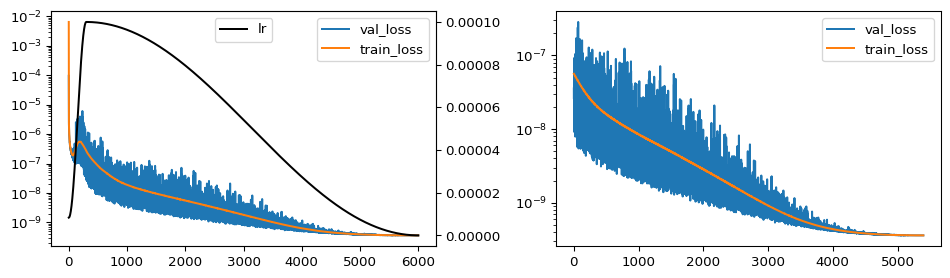

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(3.6212391455125654e-10, 3.6186819566621714e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 137.66506262123585 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 101.32078373804688 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

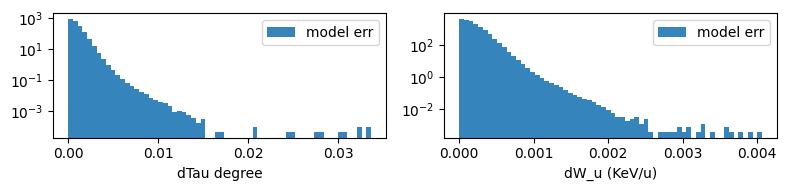

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)